## Activate current project

In [29]:
cd(@__DIR__)
using Pkg
Pkg.activate(".")

  Activating project at `~/Dropbox/code/github/deepdip/Energy_conserving_closure`


## Include dependencies

In [30]:
include("source.jl")
include("NS_FVM_solver.jl")

using Plots

## Generate meshes

### Fine mesh

In [32]:
N = (100,100) # 100 x 100 grid cells
UPC = 2 # Unknowns per grid cell, 2D so u,v
data_points = 20 # number of snapshots

dummy_data = rand(Normal(0,1),(N...,UPC,data_points)) # data_points

x = collect(LinRange(-pi, pi, N[1] + 1))
y = collect(LinRange(-pi, pi, N[2] + 1))

fine_mesh = gen_mesh(x, y, UPC=UPC); # Generate fine mesh

### Coarse mesh

In [33]:
J = (5,5) # compression factor in each direction (from fine to coarse grid)
coarse_mesh = gen_coarse_from_fine_mesh(fine_mesh,J); # Generate a coarse mesh


### Collect both meshes

Information has to be mapped between meshes. This cell makes it possible:

In [34]:

MP = gen_mesh_pair(fine_mesh,coarse_mesh); # Struct which defines the mapping from fine to coarse

# Carry out local proper orthogonal decomposition (POD)

Returns the POD modes and the singular values (S).

In [35]:
POD_modes,S = carry_out_local_SVD(dummy_data,MP,subtract_average = conserve_momentum);

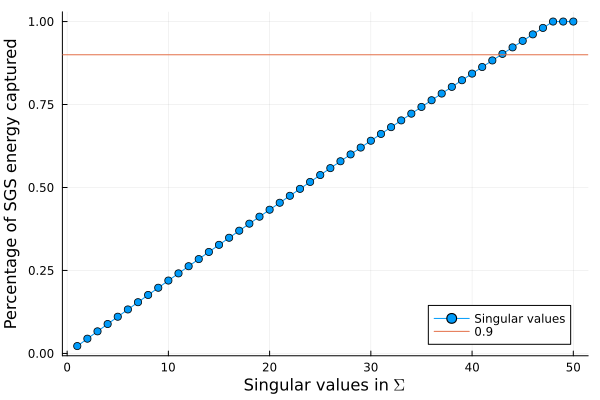

In [36]:
Plots.plot([sum(S[1:i]) for i in 1:size(S)[1]] ./ sum(S),marker = true,label = "Singular values")
hline!([0.9],label = "0.9")
xlabel!("Singular values in " * L"\Sigma")
ylabel!("Percentage of SGS energy captured")

# Local POD

We carry out the local POD and keep 10 modes per grid cell.
It transforms the full state vector into a reduced one 

$$\mathbf a = \begin{bmatrix} \bar{\mathbf{u}}  \\ \bar{\mathbf{v}} \\ \mathbf{s}_1 \\ \vdots \\ \mathbf{s}_{8} \end{bmatrix}= \boldsymbol{\Phi}^T \begin{bmatrix} \mathbf{u} \\ \mathbf{v} \end{bmatrix}.$$

The first two modes in each grid cell, $\bar{\mathbf{u}}$ and $\bar{\mathbf{v}}$, can be interpreted as an averaged version of the solution. The remaining $\mathbf{s}_i$ are latent variables that also live in the coarse grid. They don't have a straightforward physical interpretation, further than they can be projected back to the fine grid using $\boldsymbol \Phi$.

In [37]:
r =10 #how many modes to include, including u_bar and v_bar
uniform = true


global_POD_modes = local_to_global_modes(POD_modes[:,:,:,1:(r-UPC)],MP)
global_POD_modes = add_filter_to_modes(global_POD_modes,MP,orthogonalize = !uniform) ## Adds filter the POD modes


PO = gen_projection_operators(global_POD_modes,MP,uniform =uniform);

In [38]:
a = PO.W(dummy_data) # Learned representation on coarse grid
u_and_v_bar = a[:,:,1:2,:]; # First two modes ben be interpreted as an averaged version of u and v

# Generate model

In [39]:
kernel_sizes= [(1,1),(1,1)]
channels = [r+2,50] # r+2 as the first channels are the coarse rhs
strides = [(1,1),(1,1)]
B = (1,1)
boundary_padding = "c" #[["c","c"];;[0,0]] # Circular padding is applied to the input for periodic boundary conditions


constrain_energy =true # whether to use a physics constrained NN or not
dissipation = true # include dissipation if physics is constrained
conserve_momentum =true # conserve momentum if physics is constrained


model = gen_skew_NN(kernel_sizes,channels,strides,r,B,boundary_padding = boundary_padding,UPC = coarse_mesh.UPC,constrain_energy = constrain_energy,dissipation = dissipation,conserve_momentum = conserve_momentum);

0

# Model prediction

Model is formulated as a matrix operation:

$$ \mathbf{c} = \mathbf{A}(\mathbf{a},\theta)\mathbf{a}$$

where the matrix $\mathbf{A}$ is constructed from the neural network.
The full model looks as follows 

$$ \frac{\text{d}\mathbf{a}}{\text{d}t} \approx \begin{bmatrix} f_H(\bar{\mathbf{u}},\bar{\mathbf{v}}) \\ \mathbf{0 } \end{bmatrix} + \mathbf{A}(\mathbf{a},\theta)\mathbf{a},$$

where $f_H$ is the coarse right hand side.

# What is missing?

We have the averaged quantities $\bar{\mathbf{u}}$ and $\bar{\mathbf{v}}$. However, in my code this lives on a cell centred grid. We also store a single flow snapshot in an array of dimension $N_x \times N_y \times \text{d}$, where $d=2$ is the number of spatial dimensions. However in syvers code these are all contained within a vector of dimension $N_x N_y d$. One way to solve this might by (in pseudocode):

In [21]:
function convert_to_Syvers_convention(input)
    return input
end
    
    
function map_to_staggered(input)
    return input
end
        

function compute_duv_dt(input)
    return input
end

function map_to_cell_centred(input)
    return input
end
            
            
            
function convert_to_Tobys_convention(input)
    return input
end
                



convert_to_Tobys_convention (generic function with 1 method)

In [36]:
# We have the u_bar and v_bar on a cell centred grid
uv_bar = a[:,:,1:2,:]

# We require:

#1 Convert to Syvers convenction
uv_bar_syver = convert_to_Syvers_convention(uv_bar)

#2 Map to staggered grid
uv_bar_syver_staggered = map_to_staggered(uv_bar_syver)

#3 Compute dVdt
duv_dt = compute_duv_dt(uv_bar_syver_staggered)

#4 map to cell centred grid
duv_dt_cell_centred = map_to_cell_centred(duv_dt)

#5 convert to Tobys convention
duv_dt_toby = convert_to_Tobys_convention(duv_dt_cell_centred)

#6 compute c
c = model.eval(cat(a,duv_dt_toby,dims = 3),a = padding(a,2 .* B,circular = true));

#Remaining stuff



0